# Import Libraries

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import numpy as np
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from keras.callbacks import TensorBoard
from keras.models import load_model

# Load images from disk

In [16]:
print('LOADING TRAIN IMAGES:\n')
train_dataset = keras.preprocessing.image_dataset_from_directory(
    directory = './dataset/train',
    labels = 'inferred', #Los labels son generados tomando en cuenta la estructura del directorio
    label_mode = 'categorical', #Los labels los entregara de la forma = [[1], [0], [1],...] para una loss binary_crossentropy
    class_names = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS'], #Solo valido cuando se tiene inferred. lista de nombre de las clases
    color_mode = 'rgb', #Default 'rgb' convertira las imagenes en 1, 3 o 4 canales (grayscale, rgb, rgba)
    batch_size = 32, # Default 32. None entrega el dataset con muestras individuales
    image_size = (224,224), #Default (256,256). redimensiona las imagenes despues de leerlas en disco. (altura, ancho)
    shuffle = True, #Default True. mezcla la data aleatoriamente
    seed = 42, #optional. establecer semilla para mezclar y aplicar transformaciones
    interpolation = 'bilinear', # Default bilinear. metodo para aplicar resize("bilinear", "nearest", "bicubic", "area", "lanczos3", "lanczos5", "gaussian", "mitchellcubic")
    )
print('\n')
print('LOADING VALIDATION IMAGES:\n')
valid_dataset = keras.preprocessing.image_dataset_from_directory(
    directory='./dataset/val/',
    labels="inferred",
    label_mode="categorical",
    class_names=['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS'],
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    interpolation = 'bilinear'
)
print('\n')
print('LOADING TEST IMAGES:\n')
test_dataset = keras.preprocessing.image_dataset_from_directory(
    directory='./dataset/test/',
    labels="inferred",
    label_mode="categorical",
    class_names=['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS'],
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    interpolation = 'bilinear'
)
print('\n')
print('IMAGES LOADED SUCCESFULLY.')

LOADING TRAIN IMAGES:

Found 6326 files belonging to 4 classes.


LOADING VALIDATION IMAGES:

Found 38 files belonging to 4 classes.


LOADING TEST IMAGES:

Found 771 files belonging to 4 classes.


IMAGES LOADED SUCCESFULLY.


# Normalize Images

In [17]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

#Train_dataset
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#Valid_dataset
valid_dataset = valid_dataset.map(lambda x, y: (normalization_layer(x), y))
#Test_dataset
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

train_image_batch, train_labels_batch = next(iter(train_dataset))
valid_image_batch, valid_labels_batch = next(iter(valid_dataset))
test_image_batch, test_labels_batch = next(iter(test_dataset))
train_first_image = train_image_batch[0]
valid_first_image = valid_image_batch[0]
test_first_image = test_image_batch[0]

# Verificar que los valores de los pixeles estan entre [0,1].
print(f'The min and max pixel values in train_dataset images are: {(np.min(train_first_image), np.max(train_first_image))}\n')
print(f'The min and max pixel values in valid_dataset images are: {(np.min(valid_first_image), np.max(valid_first_image))}\n')
print(f'The min and max pixel values in test_dataset images are: {(np.min(test_first_image), np.max(test_first_image))}')

The min and max pixel values in train_dataset images are: (0.009035513, 0.9978242)

The min and max pixel values in valid_dataset images are: (0.041959774, 1.0)

The min and max pixel values in test_dataset images are: (0.015686275, 1.0)


# View Images

In [ ]:
# Display images
def show_images(dataset):
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):
        for i in range(32):
            ax = plt.subplot(5, 7, i + 1)
            plt.imshow(images[i].numpy())
            if np.argmax(labels[i]) == 0:
                plt.title("COVID19")
            elif np.argmax(labels[i]) == 1:
                plt.title("NORMAL")
            elif np.argmax(labels[i]) == 2:
                plt.title("PNEUMONIA")
            elif np.argmax(labels[i]) == 3:
                plt.title("TURBERCULOSIS")
            plt.axis("off")
    plt.show()

## Train Images

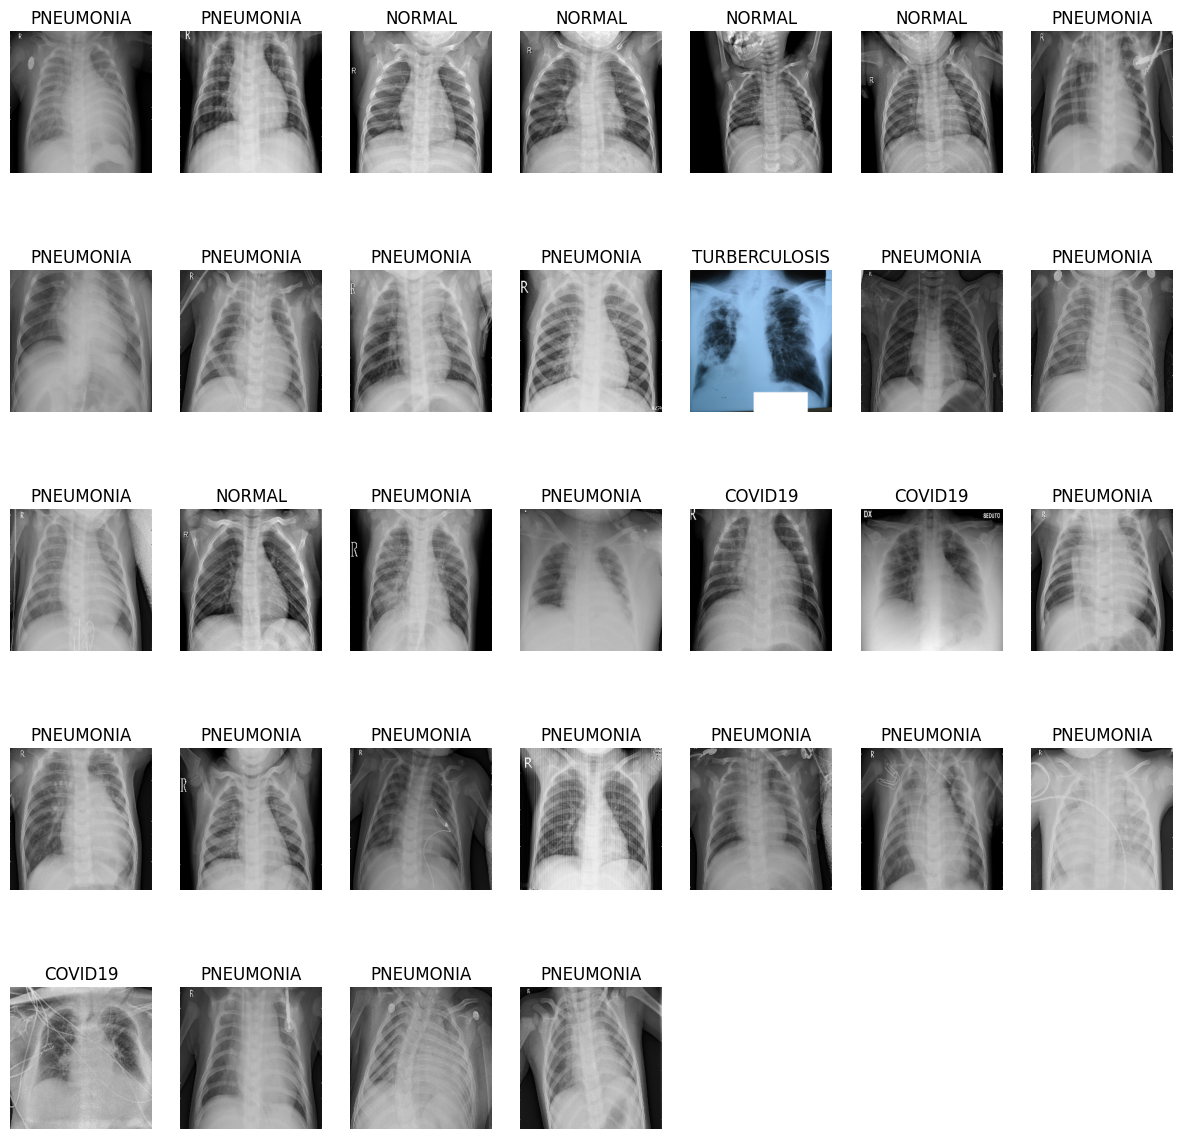

In [ ]:
# display train images
show_images(train_dataset)

## Valid Images

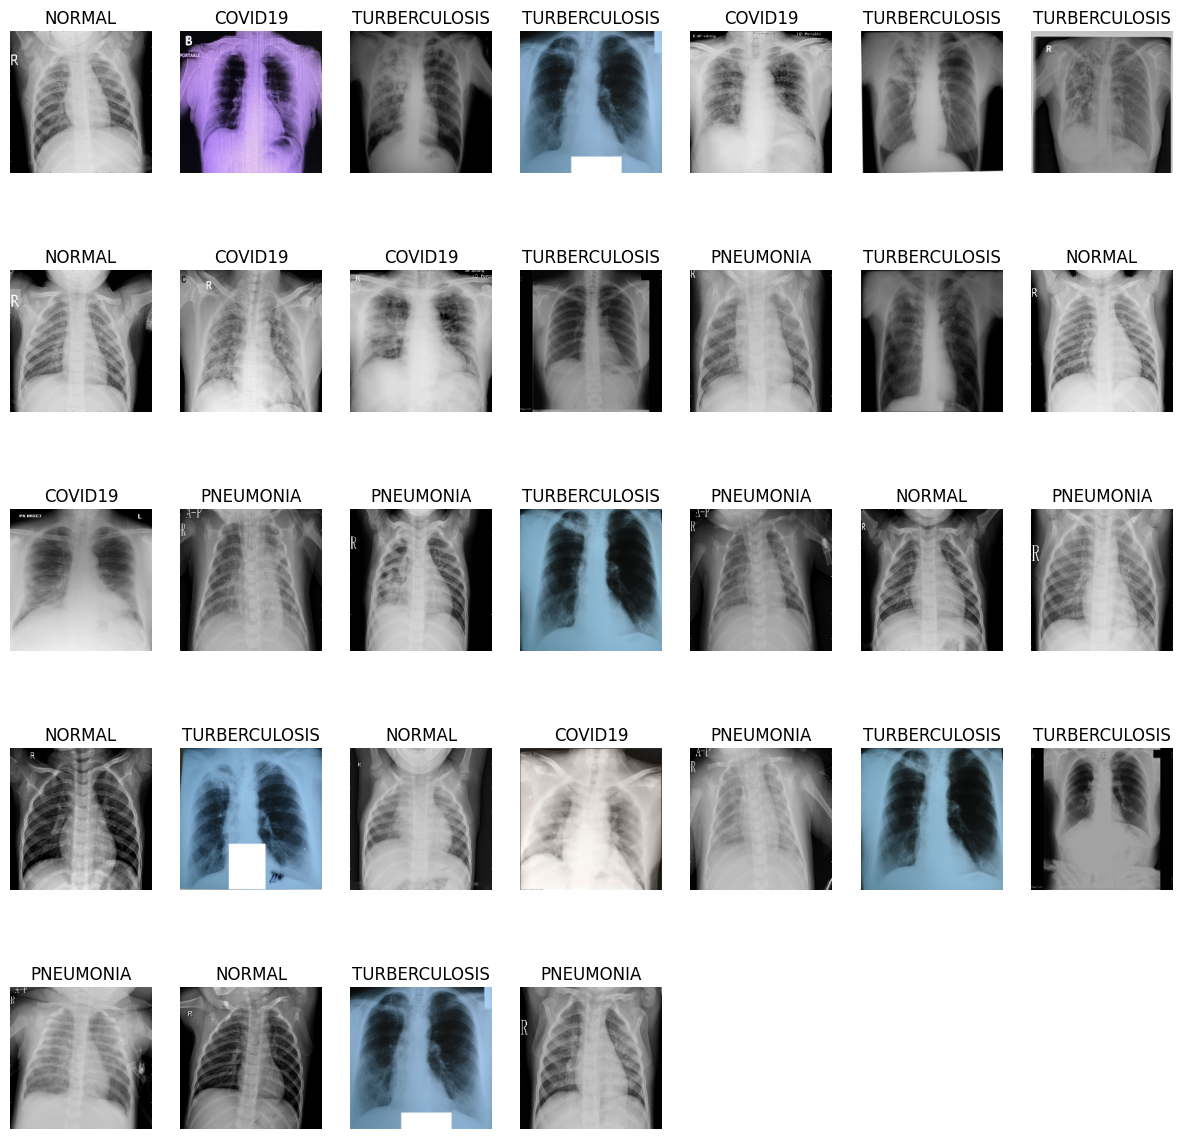

In [ ]:
# display valid images
show_images(valid_dataset)

## Test Images

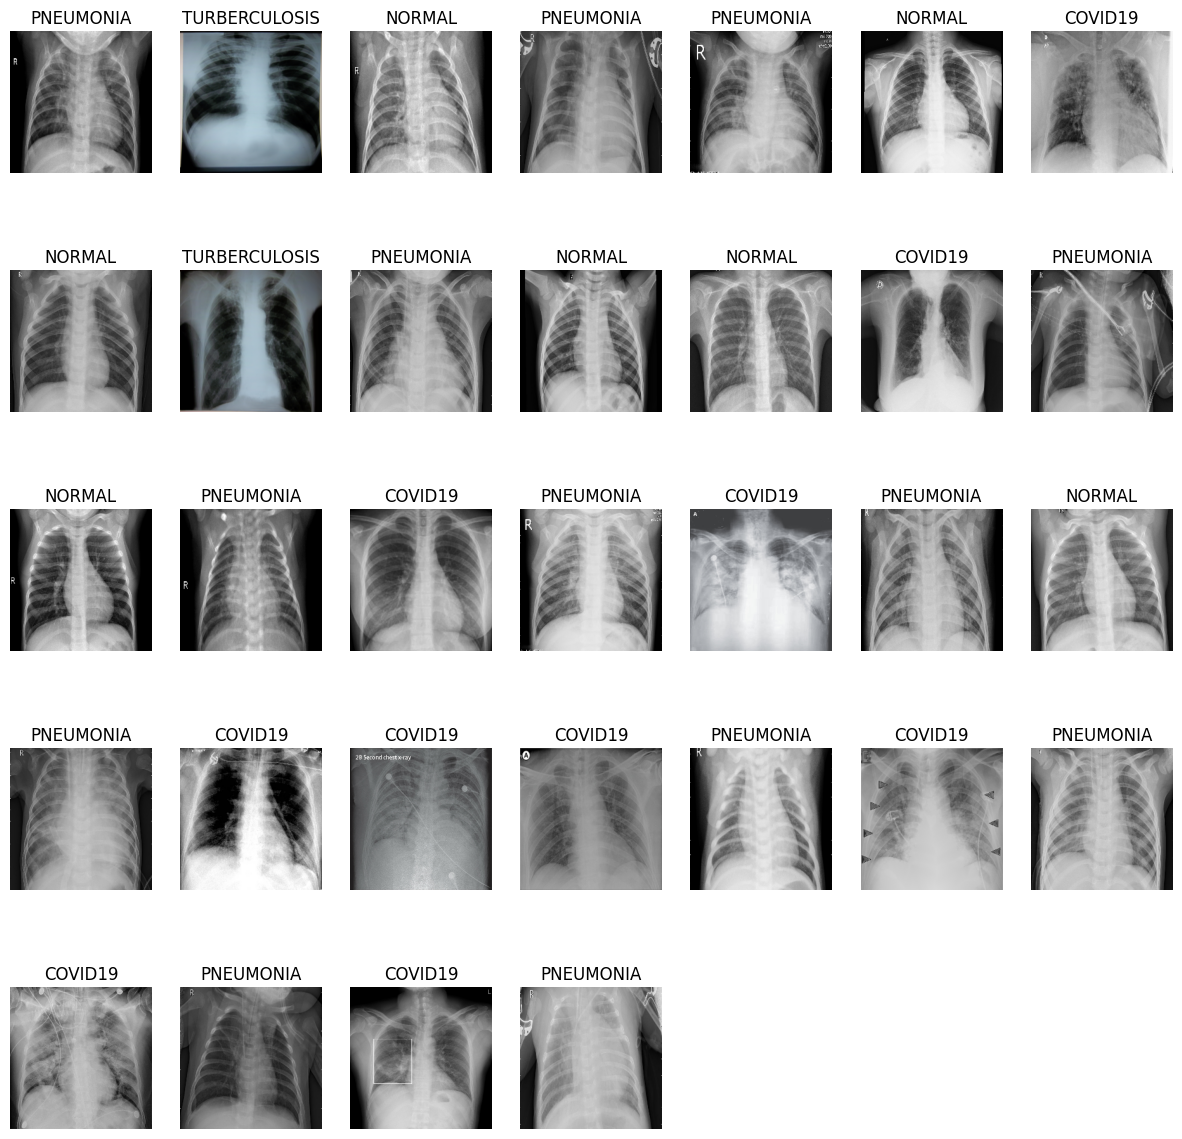

In [ ]:
# display test images
show_images(test_dataset)

# Transfer Learning

In [ ]:
#resnet50 = keras.applications.ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)
vgg = keras.applications.VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
xception = keras.applications.Xception(input_shape=(224,224,3), weights='imagenet', include_top=False)
densenet = keras.applications.DenseNet121(input_shape=(224,224,3), weights='imagenet', include_top=False)

base_models_dict = {
    #'ResNet50': resnet50,
    'VGG16': vgg,
    'Xception': xception,
    'DenseNet': densenet
}
base_models_dict

#Freeze base_model's trainable parameters
for name, model in base_models_dict.items():
    model.trainable = False


58889256/58889256 [==============================] - 0s 0us/step


83683744/83683744 [==============================] - 1s 0us/step


29084464/29084464 [==============================] - 0s 0us/step


# Build Models

In [ ]:
FC_LAYERS = [1024, 512, 256]
dropout = 0.3

def build_model(base_model, fc_layers, dropout, name):

    feature_map = base_model.output
    x = GlobalAveragePooling2D()(feature_map)

    # add Dense Layers
    for neurons in fc_layers:
        x = Dense(neurons, activation='relu')(x)
        x = Dropout(dropout)(x)

    #Ouput layer
    output = Dense(4, activation='softmax')(x)

    model = keras.Model(inputs = base_model.input, outputs = output, name=name)

    return model

In [ ]:
built_models_dict = {}
for name, model in base_models_dict.items():
    built_models_dict[name] = build_model(model, FC_LAYERS, dropout, 'built_'+name)

built_models_dict

{'VGG16': <Functional name=built_VGG16, built=True>,
 'Xception': <Functional name=built_Xception, built=True>,
 'DenseNet': <Functional name=built_DenseNet, built=True>}

## Built models arquitecture

In [ ]:
# Lets see some models arquitectures
built_models_dict['VGG16'].summary()

Model: "built_VGG16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,897,156 (60.64 MB)

 Trainable params: 1,182,468 (4.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Compile models

In [ ]:
for name, model in built_models_dict.items():
    model.compile(loss="categorical_crossentropy",
                  optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=['accuracy'])

## Training

In [ ]:
#This is for download de logs files
#this is for download files
import shutil
#shutil.make_archive('logs', 'zip', '/kaggle/working/logs')

In [ ]:
history_dict = {}
for name, model in built_models_dict.items():
    tb = TensorBoard(log_dir=f"./logs/{name}")
    print(f"Training {name}")
    history = model.fit(train_dataset, validation_data=(valid_dataset), epochs=30, callbacks=[tb])
    history_dict[name] = history
    print(f"{name} Training finished!")

Training VGG16
Epoch 1/30


I0000 00:00:1719697621.296585    1615 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719697621.317050    1615 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.6856 - loss: 0.7770

W0000 00:00:1719697676.847316    1617 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719697678.039220    1617 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719697686.738754    1616 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


198/198 ━━━━━━━━━━━━━━━━━━━━ 104s 335ms/step - accuracy: 0.6862 - loss: 0.7757 - val_accuracy: 0.7368 - val_loss: 0.9869
Epoch 2/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 27s 137ms/step - accuracy: 0.9117 - loss: 0.2404 - val_accuracy: 0.8684 - val_loss: 0.3739
Epoch 3/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 41s 138ms/step - accuracy: 0.9205 - loss: 0.2141 - val_accuracy: 0.7632 - val_loss: 0.7630
Epoch 4/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 27s 137ms/step - accuracy: 0.9306 - loss: 0.1874 - val_accuracy: 0.8158 - val_loss: 0.5428
Epoch 5/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - accuracy: 0.9434 - loss: 0.1589 - val_accuracy: 0.8421 - val_loss: 0.5554
Epoch 6/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 27s 137ms/step - accuracy: 0.9407 - loss: 0.1664 - val_accuracy: 0.7895 - val_loss: 0.5515
Epoch 7/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 28s 139ms/step - accuracy: 0.9417 - loss: 0.1566 - val_accuracy: 0.7632 - val_loss: 0.6403
Epoch 8/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 27s 137ms/step - accuracy: 0.9413 - loss: 0.1562 - va

W0000 00:00:1719698585.537035    1615 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.8054 - loss: 0.5063

W0000 00:00:1719698629.617584    1618 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719698633.077913    1615 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


198/198 ━━━━━━━━━━━━━━━━━━━━ 79s 268ms/step - accuracy: 0.8057 - loss: 0.5056 - val_accuracy: 0.6842 - val_loss: 0.9013
Epoch 2/30


W0000 00:00:1719698638.624075    1616 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


198/198 ━━━━━━━━━━━━━━━━━━━━ 26s 133ms/step - accuracy: 0.9212 - loss: 0.2155 - val_accuracy: 0.7895 - val_loss: 0.4121
Epoch 3/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - accuracy: 0.9380 - loss: 0.1879 - val_accuracy: 0.7895 - val_loss: 0.5085
Epoch 4/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - accuracy: 0.9522 - loss: 0.1499 - val_accuracy: 0.8684 - val_loss: 0.6648
Epoch 5/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 26s 133ms/step - accuracy: 0.9548 - loss: 0.1462 - val_accuracy: 0.7105 - val_loss: 0.6693
Epoch 6/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 26s 132ms/step - accuracy: 0.9576 - loss: 0.1253 - val_accuracy: 0.7895 - val_loss: 0.5147
Epoch 7/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 27s 133ms/step - accuracy: 0.9616 - loss: 0.1221 - val_accuracy: 0.7632 - val_loss: 0.5926
Epoch 8/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 27s 133ms/step - accuracy: 0.9542 - loss: 0.1272 - val_accuracy: 0.8421 - val_loss: 0.3138
Epoch 9/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 26s 133ms/step - accuracy: 0.9634 - loss: 0.1046 - val

W0000 00:00:1719699505.523014    1615 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.7710 - loss: 0.6302

W0000 00:00:1719699556.066028    1617 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719699566.744314    1615 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


198/198 ━━━━━━━━━━━━━━━━━━━━ 115s 377ms/step - accuracy: 0.7714 - loss: 0.6290 - val_accuracy: 0.8158 - val_loss: 0.4124
Epoch 2/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 25s 124ms/step - accuracy: 0.9277 - loss: 0.2058 - val_accuracy: 0.9211 - val_loss: 0.2148
Epoch 3/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 25s 123ms/step - accuracy: 0.9413 - loss: 0.1542 - val_accuracy: 0.7895 - val_loss: 0.3666
Epoch 4/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 41s 123ms/step - accuracy: 0.9565 - loss: 0.1240 - val_accuracy: 0.9211 - val_loss: 0.1451
Epoch 5/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 24s 123ms/step - accuracy: 0.9565 - loss: 0.1232 - val_accuracy: 0.8684 - val_loss: 0.2282
Epoch 6/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 25s 123ms/step - accuracy: 0.9590 - loss: 0.1168 - val_accuracy: 0.9737 - val_loss: 0.0897
Epoch 7/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 24s 122ms/step - accuracy: 0.9618 - loss: 0.1087 - val_accuracy: 0.8947 - val_loss: 0.2667
Epoch 8/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 25s 124ms/step - accuracy: 0.9659 - loss: 0.0973 - va

## Plot Metrics

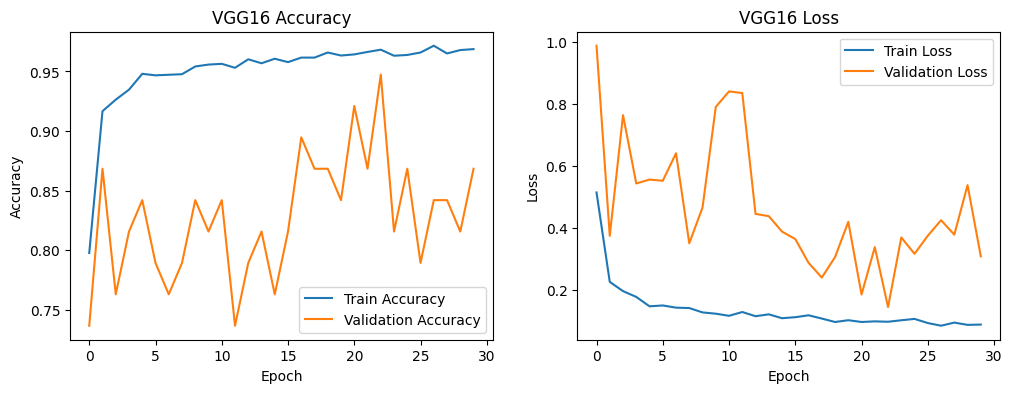

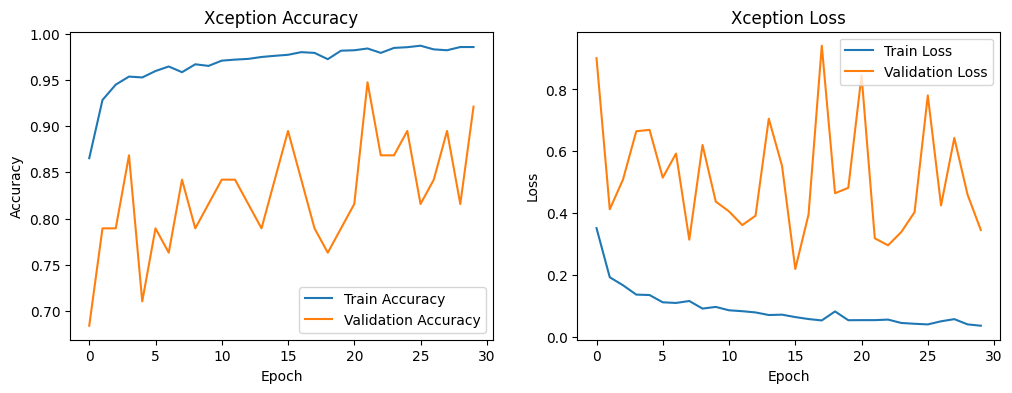

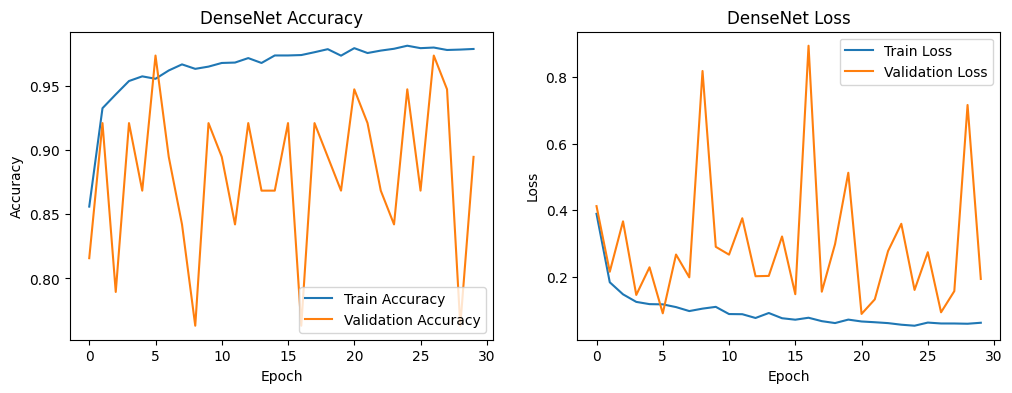

In [ ]:
def plot_history(history, model_name):
    # Resumir la historia de la precisión
    plt.figure(figsize=(12, 4))

    # Gráfico de la precisión (accuracy)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Gráfico de la pérdida (loss)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.show()

# Iterar sobre el diccionario para generar los gráficos para cada modelo
for model_name, history in history_dict.items():
    plot_history(history, model_name)

In [ ]:
!rm -r logs.zip
shutil.make_archive('logs', 'zip', '/kaggle/working/logs')

## Best Models

In [ ]:
acc_values = []
val_acc_values = []
loss_values = []
val_loss_values = []

for model, history in history_dict.items():
    acc_values.append(history.history['accuracy'][-1])
    val_acc_values.append(history.history['val_accuracy'][-1])
    loss_values.append(history.history['loss'][-1])
    val_loss_values.append(history.history['val_loss'][-1])


metrics = {"Model": list(built_models_dict.keys()),
     "Accuracy": acc_values,
     "Val_accuracy": val_acc_values,
     "Loss": loss_values,
     "Val_loss": val_loss_values}

metrics = pd.DataFrame(data=metrics)

metrics

,Model,Accuracy,Val_accuracy,Loss,Val_loss
0,VGG16,0.968701,0.868421,0.087858,0.307791
1,Xception,0.985457,0.921053,0.035201,0.345171
2,DenseNet,0.978818,0.894737,0.061292,0.193186


## Save Models

In [ ]:
built_models_dict.items()

#Save Xception
built_models_dict['Xception'].save('Xception.keras')

#Save DenseNet
built_models_dict['DenseNet'].save('DenseNet.keras')

## Load Models

In [ ]:
!ls ../input/modelo

model.keras


In [14]:
DenseNet_model = keras.saving.load_model('../input/models/DenseNet.keras')
Xception_model = keras.saving.load_model('../input/models/Xception.keras')

## Get true labels and predictions

In [ ]:
dummy_predictions_Xception = []
dummy_predictions_DenseNet = []
dummy_true_labels = []

for batch, label in test_dataset:
    dummy_true_labels.append(label.numpy())
    dummy_predictions_Xception.append(Xception_model.predict(batch, verbose = 0))
    dummy_predictions_DenseNet.append(DenseNet_model.predict(batch, verbose = 0))

last_labels = dummy_true_labels.pop()
last_predictions_Xception = dummy_predictions_Xception.pop()
last_predictions_DenseNet = dummy_predictions_DenseNet.pop()

predictions_Xception = np.array(dummy_predictions_Xception).reshape(-1,4)
predictions_DenseNet = np.array(dummy_predictions_DenseNet).reshape(-1,4)

true_labels = np.array(dummy_true_labels).reshape(-1,4)

predictions_Xception = np.concatenate((predictions_Xception, last_predictions_Xception), axis=0)
predictions_DenseNet = np.concatenate((predictions_DenseNet, last_predictions_DenseNet), axis=0)
true_labels = np.concatenate((true_labels, last_labels), axis=0)

## Confusion Matrix

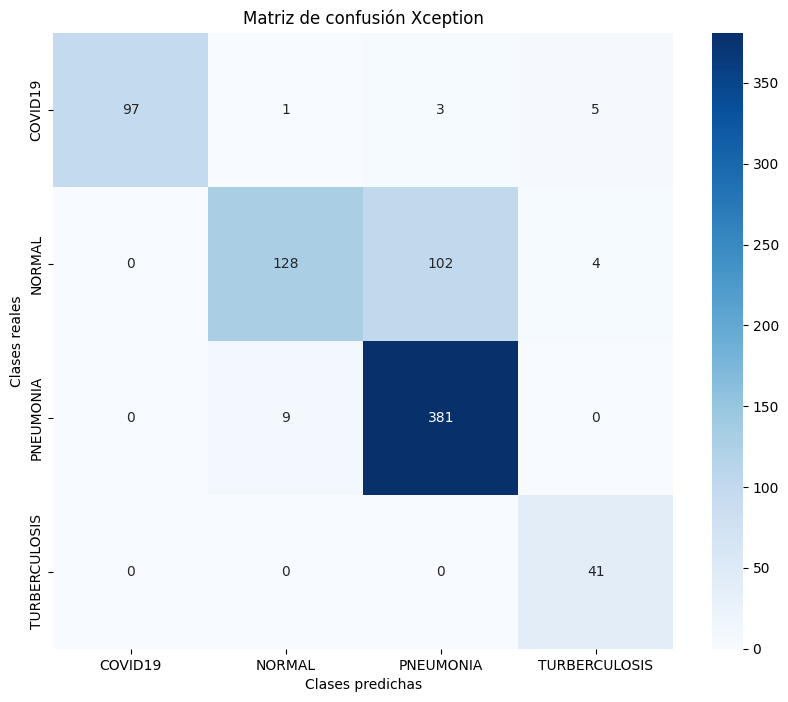

In [ ]:
y_pred_Xception = np.argmax(predictions_Xception, axis=1)
y_pred_DenseNet = np.argmax(predictions_DenseNet, axis=1)
y_true = np.argmax(true_labels, axis=1)

#PRIMERA FORMA DE CALCULAR MATRIZ DE CONFUSION
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Crear la matriz de confusión
conf_matrix1 = confusion_matrix(y_true, y_pred_Xception)

clases = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']

# Crear un mapa de calor para visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap='Blues', xticklabels=clases, yticklabels=clases)
plt.xlabel('Clases predichas')
plt.ylabel('Clases reales')
plt.title('Matriz de confusión Xception')
plt.show()

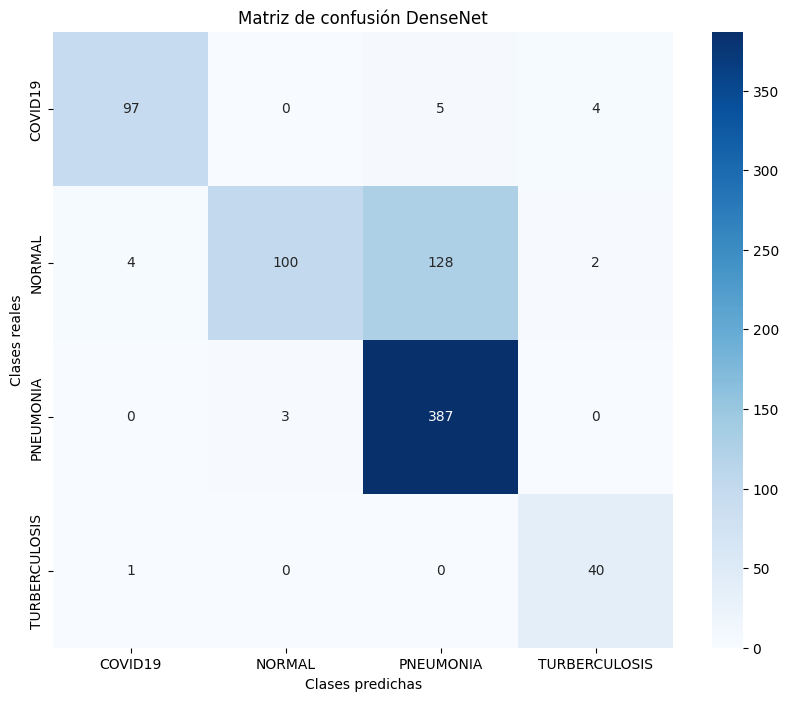

In [ ]:
conf_matrix2 = confusion_matrix(y_true, y_pred_DenseNet)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues', xticklabels=clases, yticklabels=clases)
plt.xlabel('Clases predichas')
plt.ylabel('Clases reales')
plt.title('Matriz de confusión DenseNet')
plt.show()

## Concatenate feature maps from the 2 best models

In [ ]:
model_input = tf.keras.Input(shape=(224,224,3))

DenseNet_output = base_models_dict['DenseNet'](model_input)
DenseNet_output = keras.layers.Flatten()(DenseNet_output)
Xception_output = base_models_dict['Xception'](model_input)
Xception_output = keras.layers.Flatten()(Xception_output)

# Concatenate feature maps

feature_maps = keras.layers.Concatenate(axis=-1)([DenseNet_output, Xception_output])

# Add dense layers
x = Dense(1024, activation='relu')(feature_maps)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
model_output = Dense(4, activation='softmax')(x)

## Built and compile the concatenated model

In [ ]:
model = keras.models.Model(inputs=model_input, outputs=model_output)
model.compile(loss='categorical_crossentropy',
            optimizer=keras.optimizers.Adam(learning_rate=1e-3),
            metrics=['accuracy'])

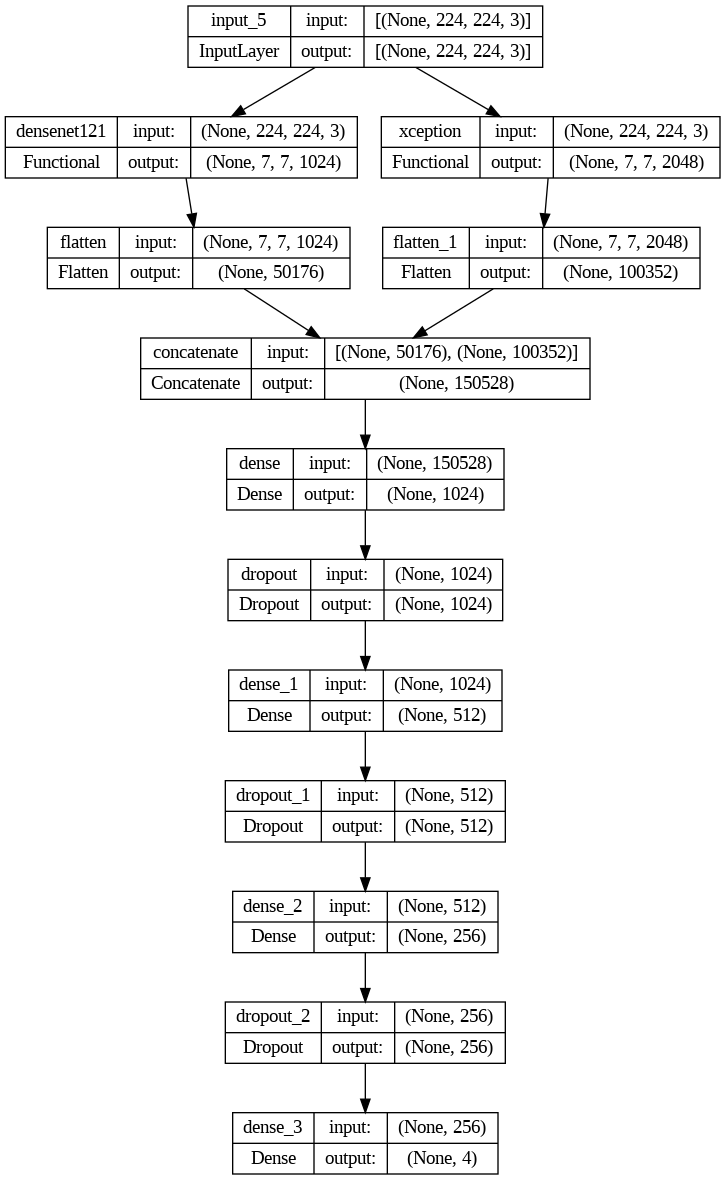

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ densenet121         │ (None, 7, 7,      │  7,037,504 │ input_layer_3[0]… │
│ (Functional)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xception            │ (None, 7, 7,      │ 20,861,480 │ input_layer_3[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 50176)     │          0 │ densenet121[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 100352)    │          0 │ xception[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 150528)    │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 1024)      │ 154,141,6… │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 1024)      │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 512)       │    524,800 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 512)       │          0 │ dense_13[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 256)       │    131,328 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 256)       │          0 │ dense_14[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 4)         │      1,028 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 182,697,836 (696.94 MB)

 Trainable params: 154,798,852 (590.51 MB)

 Non-trainable params: 27,898,984 (106.43 MB)

## Train concatenated Model

In [ ]:
#tb = TensorBoard(log_dir=f"./logs/concatenated_model")
history = model.fit(train_dataset, validation_data=(valid_dataset), epochs=30)

Epoch 1/30
  1/198 ━━━━━━━━━━━━━━━━━━━━ 1:50:16 34s/step - accuracy: 0.1250 - loss: 2.5775

W0000 00:00:1719703527.108993    1616 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.7401 - loss: 10.7028

W0000 00:00:1719703588.537257    1616 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719703600.545341    1615 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


198/198 ━━━━━━━━━━━━━━━━━━━━ 114s 406ms/step - accuracy: 0.7407 - loss: 10.6700 - val_accuracy: 0.8684 - val_loss: 0.6167
Epoch 2/30


W0000 00:00:1719703607.210911    1615 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


198/198 ━━━━━━━━━━━━━━━━━━━━ 93s 233ms/step - accuracy: 0.9285 - loss: 0.4113 - val_accuracy: 0.8947 - val_loss: 0.2808
Epoch 3/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 45s 229ms/step - accuracy: 0.9490 - loss: 0.1865 - val_accuracy: 0.9474 - val_loss: 0.1601
Epoch 4/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 46s 231ms/step - accuracy: 0.9604 - loss: 0.1389 - val_accuracy: 0.8421 - val_loss: 0.5413
Epoch 5/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 46s 230ms/step - accuracy: 0.9642 - loss: 0.1292 - val_accuracy: 0.8684 - val_loss: 0.2123
Epoch 6/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 46s 230ms/step - accuracy: 0.9743 - loss: 0.0902 - val_accuracy: 0.8947 - val_loss: 0.2463
Epoch 7/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 46s 230ms/step - accuracy: 0.9698 - loss: 0.1197 - val_accuracy: 0.9474 - val_loss: 0.2109
Epoch 8/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 83s 233ms/step - accuracy: 0.9713 - loss: 0.0984 - val_accuracy: 0.9474 - val_loss: 0.1547
Epoch 9/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 82s 232ms/step - accuracy: 0.9732 - loss: 0.0998 - val

## Plot metrics

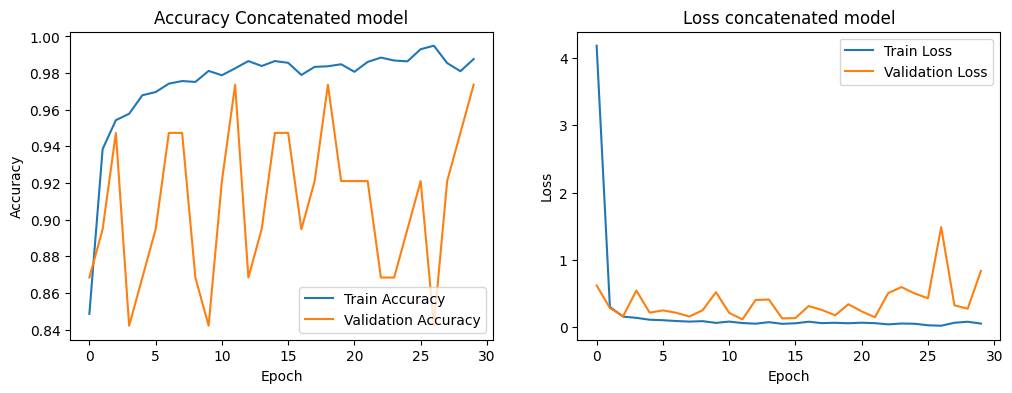

In [ ]:
# Resumir la historia de la precisión
plt.figure(figsize=(12, 4))

# Gráfico de la precisión (accuracy)
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Concatenated model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Gráfico de la pérdida (loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss concatenated model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

## Save concatenated Model

In [ ]:
!rm -r model.keras.zip model.keras.zip

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


rm: cannot remove 'model.keras.zip': No such file or directory


In [ ]:
model.save('model.keras')
shutil.make_archive('model.keras', 'zip', '/kaggle/working/model')

'/kaggle/working/model.keras.zip'

## Load Concatenated Model

In [ ]:
model = keras.saving.load_model('../input/modelo/model.keras')

## Get true labels and predictions

In [ ]:
dummy_predictions = []
dummy_true_labels = []

for batch, label in test_dataset:
    dummy_true_labels.append(label.numpy())
    dummy_predictions.append(model.predict(batch, verbose = 0))
last_labels = dummy_true_labels.pop()
last_predictions = dummy_predictions.pop()
predictions = np.array(dummy_predictions).reshape(-1,4)
true_labels = np.array(dummy_true_labels).reshape(-1,4)
predictions = np.concatenate((predictions, last_predictions), axis=0)
true_labels = np.concatenate((true_labels, last_labels), axis=0)

In [ ]:
predictions.shape, true_labels.shape

((771, 4), (771, 4))

## Confusion Matrix

In [ ]:
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(true_labels, axis=1)

In [25]:
#Save predictions and labels
#np.save('predicciones.npy',predictions)
#np.save('true_labels.npy',true_labels)
#np.save('y_pred.npy',y_pred)
#np.save('y_true.npy',y_true)

# Load Predictions and labels

predictions = np.load('../input/nparrays/predicciones.npy')
true_labels = np.load('../input/nparrays/true_labels.npy')
y_true = np.load('../input/nparrays/y_true.npy')
y_pred = np.load('../input/nparrays/y_pred.npy')

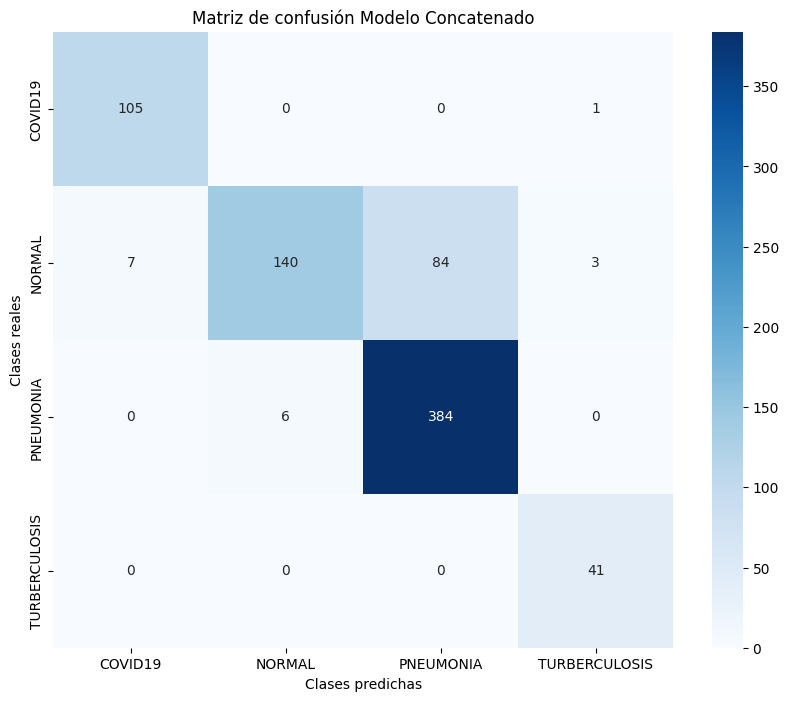

In [26]:
#PRIMERA FORMA DE CALCULAR MATRIZ DE CONFUSION
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Crear la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

clases = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']

# Crear un mapa de calor para visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clases, yticklabels=clases)
plt.xlabel('Clases predichas')
plt.ylabel('Clases reales')
plt.title('Matriz de confusión Modelo Concatenado')
plt.show()


## Get Metrics

In [12]:
def metrics(cf):
  tp_covid = np.diag(cf)[0]
  fp_covid = sum(cf[0]) - cf[0][0]
  fn_covid = sum(cf[:,0]) - cf[0][0]

  ##Normal
  tp_normal = np.diag(cf)[1]
  fp_normal = sum(cf[1]) - cf[1][1]
  fn_normal = sum(cf[:,1]) - cf[1][1]

  ##Pneumonia
  tp_pneumonia = np.diag(cf)[2]
  fp_pneumonia = sum(cf[2]) - cf[2][2]
  fn_pneumonia = sum(cf[:,2]) - cf[2][2]

  ##Tuberculosis
  tp_tuberculosis = np.diag(cf)[3]
  fp_tuberculosis = sum(cf[3]) - cf[3][3]
  fn_tuberculosis = sum(cf[:,3]) - cf[3][3]


  #cm1 metrics

  ## Covid Metrics
  covid_presicion = tp_covid/(tp_covid+fp_covid)
  covid_sensitivity = tp_covid/(tp_covid+fn_covid)
  covid_Fscore = 2*(covid_presicion*covid_sensitivity)/(covid_presicion+covid_sensitivity)

  ## Normal Metrics
  normal_presicion = tp_normal/(tp_normal+fp_normal)
  normal_sensitivity = tp_normal/(tp_normal+fn_normal)
  normal_Fscore = 2*(normal_presicion*normal_sensitivity)/(normal_presicion+normal_sensitivity)

  ## Pneumonia Metrics
  pneumonia_presicion = tp_pneumonia/(tp_pneumonia+fp_pneumonia)
  pneumonia_sensitivity = tp_pneumonia/(tp_pneumonia+fn_pneumonia)
  pneumonia_Fscore = 2*(pneumonia_presicion*pneumonia_sensitivity)/(pneumonia_presicion+pneumonia_sensitivity)

  ## tuberculosis Metrics
  tuberculosis_presicion = tp_tuberculosis/(tp_tuberculosis+fp_tuberculosis)
  tuberculosis_sensitivity = tp_tuberculosis/(tp_tuberculosis+fn_tuberculosis)
  tuberculosis_Fscore = 2*(tuberculosis_presicion*tuberculosis_sensitivity)/(tuberculosis_presicion+tuberculosis_sensitivity)

  #Micro avgs se evalua la metrica considerando sus componentes

  Presicion_Micro_Avg = (tp_covid+tp_normal+tp_pneumonia+tp_tuberculosis)/(tp_covid+tp_normal+tp_pneumonia+tp_tuberculosis+fp_covid+fp_normal+fp_pneumonia+fp_tuberculosis)
  Recall_Micro_Avg = (tp_covid+tp_normal+tp_pneumonia+tp_tuberculosis)/(tp_covid+tp_normal+tp_pneumonia+tp_tuberculosis+fn_covid+fn_normal+fn_pneumonia+fn_tuberculosis)
  F_Micro_Avg = 2*(Presicion_Micro_Avg*Recall_Micro_Avg)/(Presicion_Micro_Avg+Recall_Micro_Avg)

  #Macro avgs corresponde al promedio de los desempeños obtenido con el one vs all
  Presicion_Macro_Avg = (covid_presicion+normal_presicion+pneumonia_presicion+tuberculosis_presicion)/4
  Recall_Macro_Avg = (covid_sensitivity+normal_sensitivity+pneumonia_sensitivity+tuberculosis_sensitivity)/4
  F_Macro_Avg = (covid_Fscore+normal_Fscore+pneumonia_Fscore+tuberculosis_Fscore)/4

  # Weighted avg metrica es ponderada con el tamano de la clase
  Presicion_weighted_avg = (106*covid_presicion+234*normal_presicion+390*pneumonia_presicion+41*tuberculosis_presicion)/771
  Recall_weighted_avg = (106*covid_sensitivity+234*normal_sensitivity+390*pneumonia_sensitivity+41*tuberculosis_sensitivity)/771
  F_weighted_avg = (106*covid_Fscore+234*normal_Fscore+390*pneumonia_Fscore+41*tuberculosis_Fscore)/771

  resume = {
      'Presicion' : [covid_presicion, normal_presicion, pneumonia_presicion, tuberculosis_presicion],
      'Recall' : [covid_sensitivity, normal_sensitivity, pneumonia_sensitivity, tuberculosis_sensitivity],
      'F-Score' : [covid_Fscore, normal_Fscore, pneumonia_Fscore, tuberculosis_Fscore],
      'Presicion_Micro_Avg' : Presicion_Micro_Avg,
      'Recall_Micro_Avg' : Recall_Micro_Avg,
      'F_Micro_Avg' : F_Micro_Avg,
      'Presicion_Macro_Avg' : Presicion_Macro_Avg,
      'Recall_Macro_Avg' : Recall_Macro_Avg,
      'F_Macro_Avg' : F_Macro_Avg,
      'Presicion_Weighted_Avg' : Presicion_weighted_avg,
      'Recall_Weighted_Avg' : Recall_weighted_avg,
      'F_Weighted_Avg' : F_weighted_avg

  }

  return resume

metrics(conf_matrix)

{'Presicion': [0.9905660377358491,
  0.5982905982905983,
  0.9846153846153847,
  1.0],
 'Recall': [0.9375, 0.958904109589041, 0.8205128205128205, 0.9111111111111111],
 'F-Score': [0.963302752293578,
  0.7368421052631579,
  0.8951048951048951,
  0.9534883720930233],
 'Presicion_Micro_Avg': 0.8690012970168612,
 'Recall_Micro_Avg': 0.8690012970168612,
 'F_Micro_Avg': 0.8690012970168612,
 'Presicion_Macro_Avg': 0.893368005160458,
 'Recall_Macro_Avg': 0.9070070103032432,
 'F_Macro_Avg': 0.8871845311886635,
 'Presicion_Weighted_Avg': 0.8690012970168612,
 'Recall_Weighted_Avg': 0.8834164944220377,
 'F_Weighted_Avg': 0.8595526286918562}

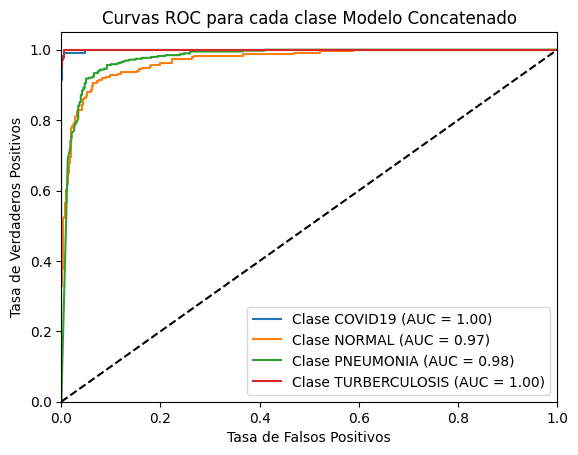

In [28]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

n_classes = clases

# Binarizar las etiquetas verdaderas
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])

# Calcular las curvas ROC y el área bajo la curva (AUC) para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(n_classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Trazar todas las curvas ROC
plt.figure()
for i in range(len(n_classes)):
    plt.plot(fpr[i], tpr[i], label=f'Clase {n_classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC para cada clase Modelo Concatenado')
plt.legend(loc="lower right")
plt.show()

## ROC CURVE DenseNet

In [19]:
dummy_predictions_Xception = []
dummy_predictions_DenseNet = []
dummy_true_labels = []

for batch, label in test_dataset:
    dummy_true_labels.append(label.numpy())
    dummy_predictions_Xception.append(Xception_model.predict(batch, verbose = 0))
    dummy_predictions_DenseNet.append(DenseNet_model.predict(batch, verbose = 0))

last_labels = dummy_true_labels.pop()
last_predictions_Xception = dummy_predictions_Xception.pop()
last_predictions_DenseNet = dummy_predictions_DenseNet.pop()

predictions_Xception = np.array(dummy_predictions_Xception).reshape(-1,4)
predictions_DenseNet = np.array(dummy_predictions_DenseNet).reshape(-1,4)

true_labels = np.array(dummy_true_labels).reshape(-1,4)

predictions_Xception = np.concatenate((predictions_Xception, last_predictions_Xception), axis=0)
predictions_DenseNet = np.concatenate((predictions_DenseNet, last_predictions_DenseNet), axis=0)
true_labels = np.concatenate((true_labels, last_labels), axis=0)

In [21]:
#y_pred = np.argmax(predictions_DenseNet, axis=1)
y_true = np.argmax(true_labels, axis=1)

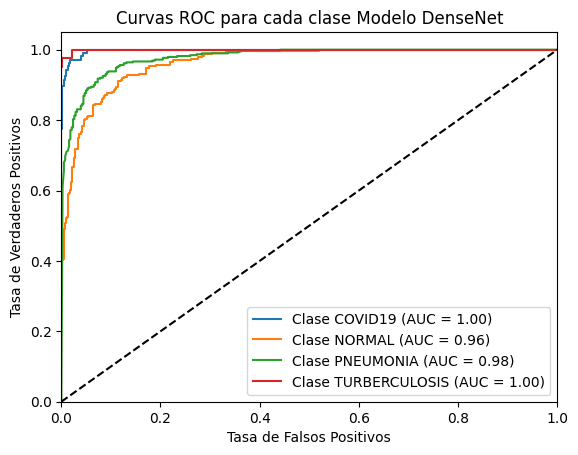

In [30]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

n_classes = clases

# Binarizar las etiquetas verdaderas
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])

# Calcular las curvas ROC y el área bajo la curva (AUC) para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(n_classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], predictions_DenseNet[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Trazar todas las curvas ROC
plt.figure()
for i in range(len(n_classes)):
    plt.plot(fpr[i], tpr[i], label=f'Clase {n_classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC para cada clase Modelo DenseNet')
plt.legend(loc="lower right")
plt.show()

## ROC CURVE Xception

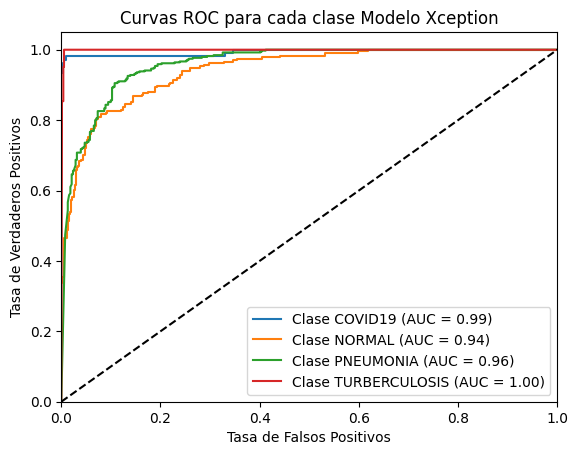

In [31]:
# Binarizar las etiquetas verdaderas
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])

# Calcular las curvas ROC y el área bajo la curva (AUC) para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(n_classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], predictions_Xception[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Trazar todas las curvas ROC
plt.figure()
for i in range(len(n_classes)):
    plt.plot(fpr[i], tpr[i], label=f'Clase {n_classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC para cada clase Modelo Xception')
plt.legend(loc="lower right")
plt.show()